In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
path = "/content/drive/MyDrive/Scocial Media Data Mining/Dataset/UIT-VSFC"
%cd /content/drive/MyDrive/Scocial Media Data Mining/Dataset/UIT-VSFC
!ls

/content/drive/.shortcut-targets-by-id/1CZcWZiWtxpQUuZayUBOYLquIpN5fLP1b/Scocial Media Data Mining/Dataset/UIT-VSFC
DataAnalysis.ipynb  README.txt	train	      VSFC_test.csv
dev		    test	VSFC_dev.csv  VSFC_train.csv


In [3]:
!pip install transformers

     |████████████████████████████████| 2.5MB 9.1MB/s 
     |████████████████████████████████| 3.3MB 36.2MB/s 
     |████████████████████████████████| 901kB 23.9MB/s 


In [4]:
from transformers import AutoTokenizer, XLMRobertaForSequenceClassification,Trainer,\
 TrainingArguments, BertTokenizer, BertForSequenceClassification, BertTokenizer,AutoModelForSequenceClassification
import torch
import torch.nn as nn 
import torch.functional as F
import pandas as pd
import numpy as np
# Xu ly label
from sklearn.preprocessing import LabelEncoder

# Metric danh gia 
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score

# Ve do thi
import seaborn as sn
import matplotlib.pyplot as plt

# Load data

In [5]:
train = pd.read_csv(path + "/VSFC_train.csv", index_col=False)
dev = pd.read_csv(path + "/VSFC_dev.csv", index_col=False)
test = pd.read_csv(path + "/VSFC_test.csv", index_col=False)

In [6]:
X_train = train['Sents']
y_train = train['Sentiments'].values

X_dev = dev['Sents']
y_dev = dev['Sentiments'].values

X_test = test['Sents']
y_test = test['Sentiments'].values

In [7]:
le = LabelEncoder()
le.fit(y_train)
y_train_encoding = le.transform(y_train)
y_dev_encoding = le.transform(y_dev)
y_test_encoding = le.transform(y_test)

In [8]:
num_labels = len(np.unique(y_test))
# Xay dung data de fit vao mo hinh 
class BuildDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):
        return len(self.labels)

# XLM-R for sentiment analysis

In [ ]:
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')
model = XLMRobertaForSequenceClassification.from_pretrained('xlm-roberta-base', num_labels = num_labels)

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForSequenceClassification: ['lm_head.decoder.weight', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.bias', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForSequenceClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.dense

In [ ]:
%cd /content/drive/MyDrive/Scocial Media Data Mining/SourceCode/Thien_XLM/UIT-VSFC/Sentiments/results_1
!ls

/content/drive/.shortcut-targets-by-id/1CZcWZiWtxpQUuZayUBOYLquIpN5fLP1b/Scocial Media Data Mining/SourceCode/Thien_XLM/UIT-VSFC/Sentiments/results_1


In [ ]:
# encoding du lieu

train_encodings = tokenizer(X_train.to_list(), truncation=True, padding=True, max_length=40)
dev_encodings = tokenizer(X_dev.to_list(), truncation=True, padding=True, max_length=40)
test_encodings = tokenizer(X_test.to_list(), truncation=True, padding=True, max_length=40)

# Chuan bi data
train_dataset = BuildDataset(train_encodings, y_train_encoding)
dev_dataset = BuildDataset(dev_encodings, y_dev_encoding)
test_dataset = BuildDataset(test_encodings, y_test_encoding)

# Chuan bi mo hinh

training_args = TrainingArguments(
    output_dir='./results',          
    num_train_epochs = 70,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=32,   
    warmup_steps=500,                
    weight_decay=0.01,
    no_cuda=False
)

trainer = Trainer(
    model=model,                         
    args=training_args,                  
    train_dataset=train_dataset,         
    eval_dataset=dev_dataset             
)

In [ ]:
trainer.train()

Step,Training Loss
500,0.444300
1000,0.248100
1500,0.199800
2000,0.155300
2500,0.136200
3000,0.102100
3500,0.095200
4000,0.083600
4500,0.071300
5000,0.061200


TrainOutput(global_step=25060, training_loss=0.0432822174827456, metrics={'train_runtime': 9925.0106, 'train_samples_per_second': 80.586, 'train_steps_per_second': 2.525, 'total_flos': 5.3372811774744e+16, 'train_loss': 0.0432822174827456, 'epoch': 70.0})

In [ ]:
# Du doan 
y_pred_classify = trainer.predict(test_dataset)

y_pred = np.argmax(y_pred_classify.predictions, axis=-1)

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
# Danh gia mo hinh
y_true = y_test_encoding
y_pred_classify = trainer.predict(test_dataset)
y_pred = np.argmax(y_pred_classify.predictions, axis=-1)
cf = confusion_matrix(y_true, y_pred, labels= pd.Series(y_true).unique())

print(cf)
print("accuracy: " + str(accuracy_score(y_true, y_pred)))
print("F1 - macro: " + str(f1_score(y_true, y_pred, average='macro')))
target_names = pd.Series(y_test).astype(str).unique()
print('Classification report in Training set')
print(classification_report(y_true, y_pred, labels=pd.Series(y_true).unique(), target_names=target_names))

[[1511   52   27]
 [  30 1361   18]
 [  54   39   74]]
accuracy: 0.930511686670878
F1 - macro: 0.8059069041342971
Classification report in Training set
              precision    recall  f1-score   support

           2       0.95      0.95      0.95      1590
           0       0.94      0.97      0.95      1409
           1       0.62      0.44      0.52       167

    accuracy                           0.93      3166
   macro avg       0.84      0.79      0.81      3166
weighted avg       0.93      0.93      0.93      3166



In [ ]:
print(pd.Series(y_test).unique())
print(pd.Series(y_true).unique())

[2 0 1]
[2 0 1]


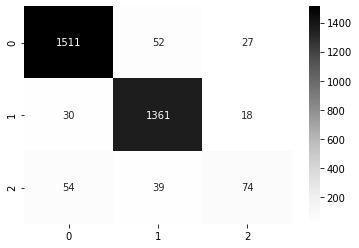

In [ ]:
# Ve ma tran nham lan
df_cm = pd.DataFrame(cf, index = np.unique(y_train),
                  columns = np.unique(y_train))

sn.heatmap(df_cm, annot=True, cmap="Greys",fmt='g', cbar=True, annot_kws={"size": 10})